# Purpose

The purpose of this notebook is to demonstrate prior and predictive checks of one's causal graphical model.

The prior checks are to be used as part of one's falsification efforts before estimating the posterior distribution of one's unknown model parameters. If one's causal model contains latent variables, then such prior checks are expected to be extremely valuable. They are expected to indicate when one's model is likely to poorly fit one's data. This information can be used to avoid a potentially lengthy model estimation process. These checks will likely be implemented with very liberal thresholds for deciding that a model is not even worth beign estimated.

The posterior predictive checks are to really ensure that the observed data is well fit by the assumptions of one's causal model.

# Logical steps
0. Determine the test statistic to be computed.
1. Require as inputs:
   1. predictive samples of all model variables (latent and observed),
   2. function to compute the desired test statistic given a sample from the causal graph,
   3. the observed data.
   4. function to plot the distribution of the simulated test statistic and the value/distribution of the observed test statistic.
2. For each predictive sample,
   1. Compute the value of the simulated and observed test statistic (assuming the observed test statistic also depends on the simulated values. If not, simply store the value of the observed test statistic and do not recompute it.)
   2. Store the simulated and observed test statistics.
3. Visualize the distribution of the simulated and observed test statistics.
4. Produce a scalar summary of the distribution of simulated test statistics if desired.

## Declare notebook parameters

In [1]:
# Declare hyperparameters for testing
NUM_PERMUTATIONS = 100
NUM_PRIOR_SAMPLES = 100

# Declare the columns to be used for testing
x1_col = 'num_cars'
x2_col = 'num_licensed_drivers'
mode_id_col = 'mode_id'

# Set the colors for plotting
ORIG_COLOR = '#045a8d'
SIMULATED_COLOR = '#a6bddb'

# Declare paths to data
DATA_PATH =\
    '../../data/raw/spring_2016_all_bay_area_long_format_plus_cross_bay_col.csv'

## Execute needed imports

In [2]:
import sys

import numpy as np
import pandas as pd
from scipy.stats import norm

import seaborn as sbn
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from causalgraphicalmodels import CausalGraphicalModel

sys.path.insert(0, '../../src/')
import viz

## Create needed functions for analysis

In [3]:
def _make_regressor(x_2d, y, seed=None):
    # regressor_kwargs =\
    #     regressor = LinearRegression()
    #     {'min_samples_leaf': MIN_SAMPLES_LEAF,
    #      'max_samples': 0.8}
    # if seed is not None:
    #     regressor_kwargs['random_state'] = seed + 10
    # regressor =\
    #     RandomForestRegressor(**regressor_kwargs)
    regressor = LinearRegression()
    regressor.fit(x_2d, y)
    return regressor


def computed_vs_obs_r2(x1_array,
                       x2_array,
                       z_array,
                       seed,
                       progress=True):
    # Combine the various predictors
    combined_obs_predictors =\
        np.concatenate((x2_array[:, None], z_array[:, None]), axis=1)

    # Determine the number of rows being plotted
    num_rows = x1_array.shape[0]

    # Create a regressor to be used to compute the conditional expectations
    regressor = _make_regressor(combined_obs_predictors, x1_array, seed)

    # Get the observed expectations
    obs_expectation = regressor.predict(combined_obs_predictors)
    obs_r2 = r2_score(x1_array, obs_expectation)

    # Initialize arrays to store the permuted expectations and r2's
    permuted_expectations = np.empty((num_rows, NUM_PERMUTATIONS))
    permuted_r2 = np.empty(NUM_PERMUTATIONS, dtype=float)

    # Get the permuted expectations
    shuffled_index_array = np.arange(num_rows)

    iterable = range(NUM_PERMUTATIONS)
    if progress:
        iterable = tqdm(iterable)

    for i in iterable:
        # Shuffle the index array
        np.random.shuffle(shuffled_index_array)
        # Get the new set of permuted X_2 values
        current_x2 = x2_array[shuffled_index_array]
        # Get the current combined predictors
        current_predictors =\
            np.concatenate((current_x2[:, None], z_array[:, None]), axis=1)
        # Fit a new model and store the current expectation
        current_regressor =\
            _make_regressor(current_predictors, x1_array, seed)
        permuted_expectations[:, i] =\
            current_regressor.predict(current_predictors)
        permuted_r2[i] = r2_score(x1_array, permuted_expectations[:, i])
    return obs_r2, permuted_r2


def compute_pvalue(obs_r2, permuted_r2):
    return (obs_r2 < permuted_r2).mean()


def compute_predictive_independence_test_values(samples, obs_sample, seed):
    """
    test_values = p-values of conditional independence test
    """
    # Determine the number of samples in order to create an iterable for
    # getting and storing test samples
    if len(samples.shape) != 3:
        msg = '`samples` should have shape (num_rows, 3, num_samples).'
        raise ValueError(msg)
    num_samples = samples.shape[-1]

    # Initialize a container for the p-values of the sampled and observed data
    sampled_pvals = np.empty((num_samples,), dtype=float)
    obs_pvals = np.empty((num_samples,), dtype=float)

    # Create the iterable to be looped over to compute test values
    iterable = viz.progress(range(NUM_PERMUTATIONS))

    # Populate the arrays of test statistics
    for i in iterable:
        # Get the data to be used to calculate this set of p-values
        current_sim_sample = samples[:, :, i]
        current_sim_z = current_sim_sample[:, -1]
        current_augmented_obs =\
            np.concatenate((obs_sample, current_sim_z[:, None]),
                           axis=1)

        # Package the arguments to compute the predictive r2 values
        sim_args =\
            (current_sim_sample[:, 0],
             current_sim_sample[:, 1],
             current_sim_z,
             seed,
             False
            )

        augmented_obs_args =\
            (current_augmented_obs[:, 0],
             current_augmented_obs[:, 1],
             current_augmented_obs[:, 2],
             seed,
             False
            )

        # Compute and store the p-values of the conditional independence
        # test for the current simulated and augmented dataset
        sampled_pvals[i] =\
            compute_pvalue(*computed_vs_obs_r2(*sim_args))

        obs_pvals[i] =\
            compute_pvalue(*computed_vs_obs_r2(*augmented_obs_args))
    return sampled_pvals, obs_pvals


def visualize_predictive_cit_results(
        sampled_pvals,
        obs_pvals,
        verbose=True,
        show=True,
        close=False):
    sbn.set_style('white')
    fig, ax = plt.subplots(figsize=(10, 6))
    overall_p_value = (obs_pvals < sampled_pvals).mean()

    if verbose:
        msg =\
            'The p-value of the predictive, permutation C.I.T. is {:.2f}.'
        print(msg.format(overall_p_value))

    sbn.distplot(
        sampled_pvals, ax=ax, color=SIMULATED_COLOR, label='Simulated', kde=False)
    sbn.distplot(
        obs_pvals, ax=ax, color=ORIG_COLOR, label='Observed', kde=False)

    ax.set_xlabel('Permutation P-value', fontsize=13)
    ax.set_ylabel(
        'Density', fontdict={'fontsize':13, 'rotation':0}, labelpad=40)
    ax.legend(loc='best')
    sbn.despine()
    if show:
        fig.show()
    if close:
        plt.close(fig=fig)
    return overall_p_value


def perform_visual_predictive_cit_test(
        samples,
        obs_sample,
        seed=1038,
        verbose=True,
        show=True,
        close=False):
    """
    Parameters
    ----------
    samples : 3D ndarray of shape (num_rows, 3, num_samples).
        Columns should contain, in order, simulated x1, x2, z.
    obs_sample : 2D ndarray of shape (num_rows, 2)
        Columns should contain, in order, observed x1, observed x2.
    """
    # Set a random seed for reproducibility
    if seed is not None:
        np.random.seed(seed)

    # Compute the observed and sampled pvalues
    sampled_pvals, obs_pvals =\
        compute_predictive_independence_test_values(
            samples, obs_sample, seed)

    # Visualize the results of the predictive permutation CIT test
    overall_p_value =\
        visualize_predictive_cit_results(
            sampled_pvals, obs_pvals, verbose=verbose,
            show=show, close=close)
    return overall_p_value, sampled_pvals, obs_pvals


## Extract data for the factor model checks

In [4]:
# Load the raw data
df = pd.read_csv(DATA_PATH)

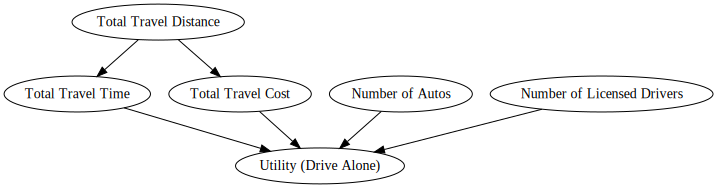

In [5]:
# Note the variables that take part in the drive alone utility
# The following cell is taken from 5.0pmab-simulation-causal-graph.ipynb
V_Drive_Alone =\
    CausalGraphicalModel(
        nodes=["Total Travel Distance",
               "Total Travel Time",
               "Total Travel Cost",
               "Number of Autos",
               "Number of Licensed Drivers",
               "Utility (Drive Alone)"],
         edges=[("Total Travel Distance","Total Travel Time"),
                ("Total Travel Distance","Total Travel Cost"),
                ("Total Travel Time", "Utility (Drive Alone)"), 
                ("Total Travel Cost", "Utility (Drive Alone)"), 
                ("Number of Autos", "Utility (Drive Alone)"),
                ("Number of Licensed Drivers","Utility (Drive Alone)")
    ]
)

# draw the causal model
V_Drive_Alone.draw()

In [6]:
# Create a list of the variables in the drive alone utility
drive_alone_variables =\
    ['total_travel_distance',
     'total_travel_cost',
     'total_travel_time',
     'num_cars',
     'num_licensed_drivers'
    ]

# Create a sub-dataframe with those variables
drive_alone_df =\
    df.loc[df['mode_id'] == 1, drive_alone_variables]

# Get the means and standard deviations of those variables
drive_alone_means = drive_alone_df.mean()
drive_alone_means.name = 'mean'

drive_alone_stds = drive_alone_df.std()
drive_alone_stds.name = 'std'

# Look at the computed means and standard deviations
print(pd.DataFrame([drive_alone_means, drive_alone_stds]))

      total_travel_distance  total_travel_cost  total_travel_time  num_cars  \
mean              15.579498           3.289287          29.667137  2.050999   
std               18.465879           4.214448          24.586569  0.880458   

      num_licensed_drivers  
mean              2.178759  
std               0.751621  


## Specify the factor model that is to be checked

In Wang and Blei's deconfounder technique, we fit a factor model to the variables in one's outcome model.

The factor model being considered here is:

$
\begin{aligned}
X_{\textrm{standardized}} &= Z * W + \epsilon\\
\textrm{where } \epsilon &= \left[ \epsilon_1, \epsilon_2, ..., \epsilon_D \right]\\
\epsilon_d &\in \mathbb{R}^{\textrm{N x 1}}\\
\epsilon_d &\sim \mathcal{N} \left(0, \sigma \right) \forall d \in \left\lbrace 1, 2, ... D \right\rbrace\\
Z &\in \mathbb{R}^{\textrm{N x 1}}\\
Z &\sim \mathcal{N} \left(0, 1 \right)\\
W &\in \mathbb{R}^{1 x D}\\
W &\sim \mathcal{N} \left(0, 1 \right)\\
N &= \textrm{Number of rows in X_standardized}\\
D &= \textrm{Number of columns in X_standardized}
\end{aligned}
$

In [7]:
# Note the number of dimensions
num_dimensions = len(drive_alone_variables)

# Specify the prior distributions for the factor
# model of the standardized drive alone dataframe
w_dist_prior = norm(loc=0, scale=1)
z_dist_prior = norm(loc=0, scale=1)

sigma_prior = 0.1
epsilon_dists_prior =\
    [norm(loc=0, scale=sigma_prior) for i in range(num_dimensions)]

## Generate prior predictive samples

In [8]:
# Get the number of observations for this utility
num_drive_alone_obs = drive_alone_df.shape[0]

# Set a seed for reproducibility
np.random.seed(721)

# Get prior samples of X_standardized
w_samples_prior =\
    w_dist_prior.rvs((1, num_dimensions, NUM_PRIOR_SAMPLES))
z_samples_prior =\
    z_dist_prior.rvs((num_drive_alone_obs, 1, NUM_PRIOR_SAMPLES))

epsilon_samples_prior =\
    np.concatenate(
        [dist.rvs((num_drive_alone_obs, NUM_PRIOR_SAMPLES))[:, None, :]
         for dist in epsilon_dists_prior],
        axis=1)

x_standardized_samples_prior =\
    (np.einsum('mnr,ndr->mdr', z_samples_prior, w_samples_prior) +
     epsilon_samples_prior)

# Get samples of X on the original scale of each variable
x_samples_prior =\
    (x_standardized_samples_prior *
     drive_alone_stds[None, :, None] +
     drive_alone_means[None, :, None])

In [9]:
# Look at the dimensions of the prior predictive samples
print(x_samples_prior.shape)

(3804, 5, 100)


## Visualize the prior predictive distribution

/Users/tbrathwaite/anaconda2/envs/causalTRB2020/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


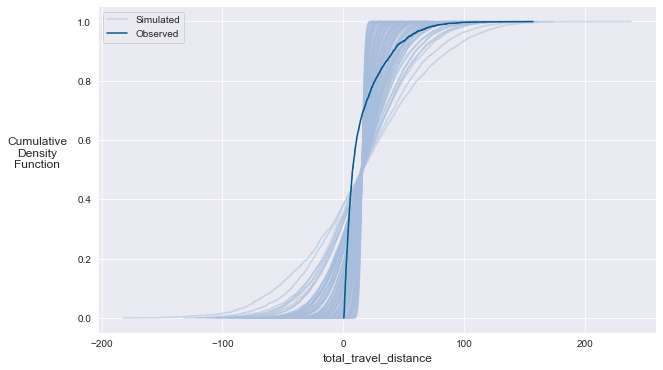

In [10]:
# Visualize the prior predictive ditributions
from viz.sim_cdf import _plot_single_cdf_on_axis

# Choose colors
orig_color = '#045a8d'
sim_color = '#a6bddb'

# Choose a column of data to compare
current_col = 0

# Create the figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the simulated cdfs
for sim_id in range(NUM_PRIOR_SAMPLES):
    label = 'Simulated' if sim_id == 0 else None
    _plot_single_cdf_on_axis(
        x_samples_prior[:, current_col, sim_id], ax, color=sim_color, label=label, alpha=0.5)
    
# Plot the observed cdf
_plot_single_cdf_on_axis(
    drive_alone_df.iloc[:, current_col],
    ax, color=orig_color, label='Observed', alpha=1.0)

# Label the plot axes
ax.set_xlabel("{}".format(drive_alone_variables[current_col]), fontsize=12)
ax.set_ylabel("Cumulative\nDensity\nFunction",
              rotation=0, labelpad=40, fontsize=12)

# Show the line labels
plt.legend(loc='best')

sbn.despine()
fig.show()

Based on the plot above, it's clear that the currently chosen prior is quite poor.

In other words, there are highly visible levels of prior-data conflict.

This lets us know that the prior predictive check of the deconfounder assumptions is likely to fail since the prior in general is a poor one, even without considering specific checks like conditional independence tests.

### Perform the prior predictive conditional independence test

In [11]:
# Get the values to be used for testing
obs_x1 =\
    (drive_alone_df.iloc[:, drive_alone_variables.index(x1_col)]
                   .values)
obs_x2 =\
    (drive_alone_df.iloc[:, drive_alone_variables.index(x2_col)]
                   .values)
obs_sample =\
    np.concatenate((obs_x1[:, None], obs_x2[:, None]), axis=1)


The p-value of the predictive, permutation C.I.T. is 0.99.


/Users/tbrathwaite/anaconda2/envs/causalTRB2020/lib/python3.7/site-packages/ipykernel_launcher.py:146: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


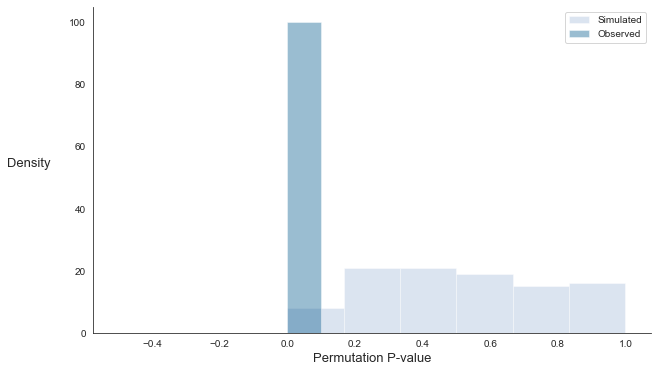

In [12]:
cols_for_test =\
    [drive_alone_variables.index(col) for col in [x1_col, x2_col]]
# Get the prior predictive values for the test
prior_samples_triplet =\
    np.concatenate((x_samples_prior[:, cols_for_test, :],
                    z_samples_prior),
                   axis=1)

# Test out the predictive conditional independence test
pval, sampled_pvals, obs_pvals =\
    perform_visual_predictive_cit_test(
        prior_samples_triplet,
        obs_sample)

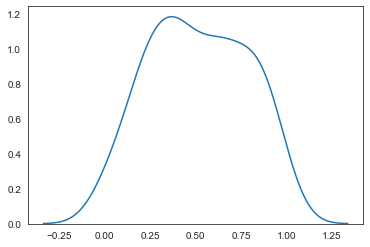

In [13]:
sbn.kdeplot(sampled_pvals)

In [14]:
print(obs_pvals)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


As indicated by the observed p-values, the observed data is strongly refuted (in absolute terms) by a conditional independence test. This is shown by the p-values of zero above.

As indicated by the relative comparison of the observed p-values to the simulated p-values, the p-values generated by the observed data are very different from the p-values generated by the prior (which is known to satisfy the desired conditional independencies).

However, both of these points are somewhat moot since the prior is in general terrible.

## Posterior Predictive Conditional Independence Tests

In [15]:
# Note that these files are based on using the `confounder`
# function from `Causal_Graph_Tim_Data.ipynb`, where the
# confounder function replicates the PPCA model of Wang
# and Blei (2018)
path_to_w_params = '../../data/processed/W_inferred_PPCA.csv'
path_to_z_params = '../../data/processed/Z_inferred_PPCA.csv'

# Load the parameters of the variational approximation to 
# the posterior distribution over W and Z
w_post_params = pd.read_csv(path_to_w_params, index_col=0)
z_post_params = pd.read_csv(path_to_z_params, index_col=0)

In [16]:
w_post_params['w_var_inferred'] = w_post_params['w_std_inferred']**2
w_post_params

,w_mean_inferred,w_std_inferred,w_var_inferred
0,1.215177,0.006481,0.000042
1,-0.069146,0.006726,0.000045
2,2.085687,0.006190,0.000038
3,-0.325767,0.009528,0.000091
4,-0.330680,0.011007,0.000121


In [17]:
# Create the posterior distribution of
w_dist_post =\
    norm(loc=w_post_params['w_mean_inferred'].values,
         scale=w_post_params['w_std_inferred'].values)

z_dist_post =\
    norm(loc=z_post_params['z_mean_inferred'].values,
         scale=z_post_params['z_std_inferred'].values)

In [18]:
# Set a seed for reproducibility
np.random.seed(852)

# Get posterior samples of X_standardized
w_samples_post =\
    w_dist_prior.rvs((num_dimensions, NUM_PRIOR_SAMPLES))
z_samples_post =\
    z_dist_prior.rvs((num_drive_alone_obs, NUM_PRIOR_SAMPLES))

# Convert the posterior samples to have the desired shapes
w_samples_post = w_samples_post[None, :, :]
z_samples_post = z_samples_post[:, None, :]

# Sample epsilon to form the posterior samples of X_standardized
epsilon_samples_post =\
    np.concatenate(
        [dist.rvs((num_drive_alone_obs, NUM_PRIOR_SAMPLES))[:, None, :]
         for dist in epsilon_dists_prior],
        axis=1)

x_standardized_samples_post =\
    (np.einsum('mnr,ndr->mdr', z_samples_post, w_samples_post) +
     epsilon_samples_post)

# Get samples of X on the original scale of each variable
x_samples_post =\
    (x_standardized_samples_post *
     drive_alone_stds[None, :, None] +
     drive_alone_means[None, :, None])

In [19]:
# Look at the dimensions of the prior predictive samples
print(x_samples_post.shape)

(3804, 5, 100)


### Visualize the posterior predictive distribution

/Users/tbrathwaite/anaconda2/envs/causalTRB2020/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


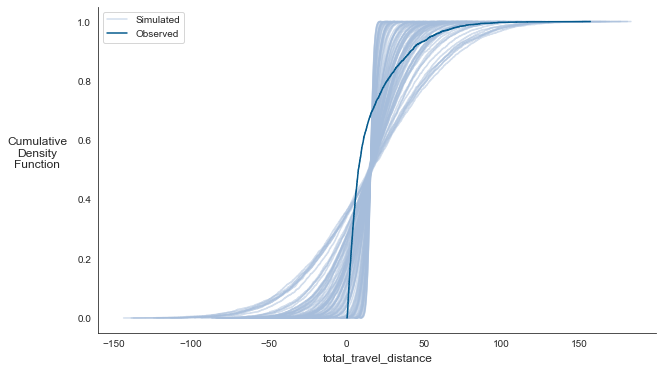

In [20]:
# Visualize the prior predictive ditributions
from viz.sim_cdf import _plot_single_cdf_on_axis

# Choose colors
orig_color = '#045a8d'
sim_color = '#a6bddb'

# Choose a column of data to compare
current_col = 0

# Create the figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the simulated cdfs
for sim_id in range(NUM_PRIOR_SAMPLES):
    label = 'Simulated' if sim_id == 0 else None
    _plot_single_cdf_on_axis(
        x_samples_post[:, current_col, sim_id], ax, color=sim_color, label=label, alpha=0.5)
    
# Plot the observed cdf
_plot_single_cdf_on_axis(
    drive_alone_df.iloc[:, current_col],
    ax, color=orig_color, label='Observed', alpha=1.0)

# Label the plot axes
ax.set_xlabel("{}".format(drive_alone_variables[current_col]), fontsize=12)
ax.set_ylabel("Cumulative\nDensity\nFunction",
              rotation=0, labelpad=40, fontsize=12)

# Show the line labels
plt.legend(loc='best')

sbn.despine()
fig.show()

In [21]:
# Compare a single sample from the prior and posterior distributions
# to the observed data
total_travel_dist_samples =\
    pd.DataFrame({'total_travel_distance_prior': x_samples_prior[:, 0, 0],
                  'total_travel_distance_post': x_samples_post[:, 0, 0],
                  'total_travel_distance_obs':
                      drive_alone_df['total_travel_distance'].values})

total_travel_dist_samples.describe()

,total_travel_distance_prior,total_travel_distance_post,total_travel_distance_obs
count,3804.000000,3804.000000,3804.000000
mean,15.489261,15.511790,15.579498
std,3.376269,5.521699,18.465879
min,4.157128,-3.936008,0.400000
25%,13.164154,11.796725,3.497500
50%,15.488496,15.460521,7.730000
75%,17.710862,19.275645,21.257500
max,27.587094,34.115920,157.150000


The plot above summarizes the posterior distribution of the total travel distance.
Similar to the prior distribution of the same variable, the posterior poorly fits the data.
As before, we can immediately expect the posterior predictive version of the conditional independence to fail since the observed data is generally unlike the sampled data.
This is dissimilarity is, a-priori, expected to remain in the conditional independence test.


The p-value of the predictive, permutation C.I.T. is 0.97.


/Users/tbrathwaite/anaconda2/envs/causalTRB2020/lib/python3.7/site-packages/ipykernel_launcher.py:146: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


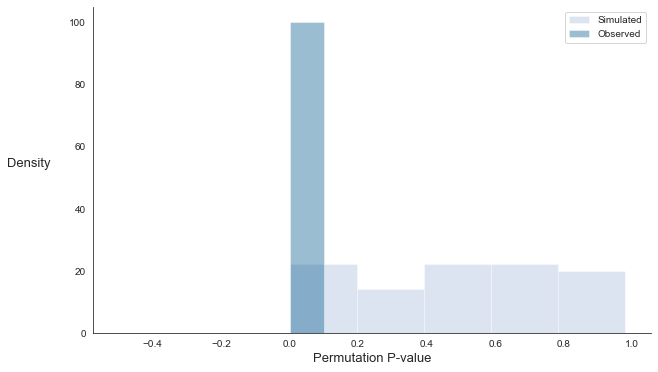

In [22]:
# Get the prior predictive values for the test
posterior_samples_triplet =\
    np.concatenate((x_samples_post[:, cols_for_test, :],
                    z_samples_post),
                   axis=1)

# Test out the predictive conditional independence test
post_pval, post_sampled_pvals, post_obs_pvals =\
    perform_visual_predictive_cit_test(
        posterior_samples_triplet,
        obs_sample)

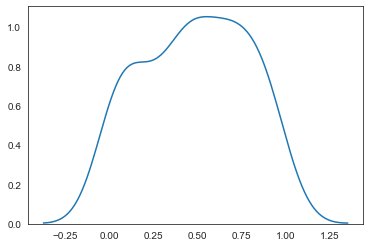

In [23]:
sbn.kdeplot(post_sampled_pvals)

In [24]:
print(post_obs_pvals)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


# Test the predictive conditional independence tests
Make sure that the predictive condidtional independence tests are passed when using data that we know satisfies the independence assumptions being tested


The p-value of the predictive, permutation C.I.T. is 0.98.


/Users/tbrathwaite/anaconda2/envs/causalTRB2020/lib/python3.7/site-packages/ipykernel_launcher.py:146: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


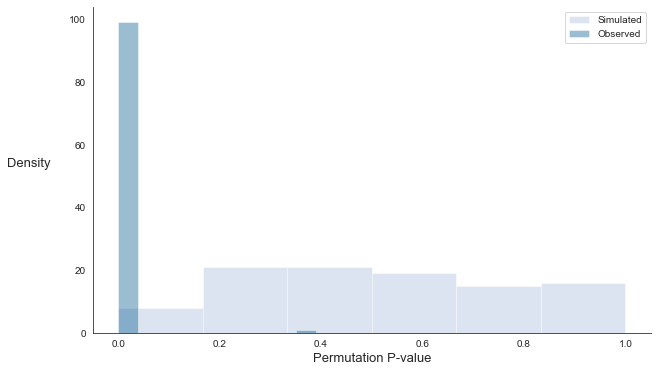

In [25]:
chosen_sim_idx = 50

# Test the predictive C.I.T with a prior sample
prior_sim_sample = x_samples_prior[:, cols_for_test, chosen_sim_idx]
prior_pval_sim, prior_sampled_pvals_sim, prior_obs_pvals_sim =\
    perform_visual_predictive_cit_test(
        prior_samples_triplet,
        prior_sim_sample)

In [26]:
prior_sampled_pvals_sim

array([0.82, 0.69, 0.36, 0.69, 0.63, 0.3 , 0.6 , 0.47, 0.7 , 0.37, 0.2 ,
       0.85, 0.86, 0.8 , 0.14, 0.62, 0.4 , 0.38, 0.  , 0.26, 0.42, 0.93,
       0.39, 0.82, 0.66, 0.56, 0.31, 0.22, 0.93, 0.86, 0.27, 0.31, 0.5 ,
       0.82, 0.55, 0.68, 0.06, 0.2 , 0.58, 0.34, 0.29, 0.24, 0.14, 0.56,
       1.  , 0.33, 0.39, 0.79, 0.24, 0.66, 0.29, 0.64, 0.64, 0.64, 0.62,
       0.41, 0.2 , 0.94, 0.23, 0.02, 0.21, 0.22, 0.51, 0.17, 0.47, 0.8 ,
       0.04, 0.34, 0.87, 0.9 , 0.95, 0.95, 0.43, 0.85, 0.75, 0.84, 0.4 ,
       0.48, 0.45, 0.77, 0.49, 0.2 , 0.41, 0.63, 0.93, 0.41, 0.53, 0.62,
       0.9 , 0.74, 0.79, 0.17, 0.71, 0.05, 0.87, 0.46, 0.27, 0.38, 0.62,
       0.04])

In [27]:
prior_obs_pvals_sim

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.39, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  ])

Automatic pdb calling has been turned ON



The p-value of the predictive, permutation C.I.T. is 0.96.


/Users/tbrathwaite/anaconda2/envs/causalTRB2020/lib/python3.7/site-packages/ipykernel_launcher.py:146: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


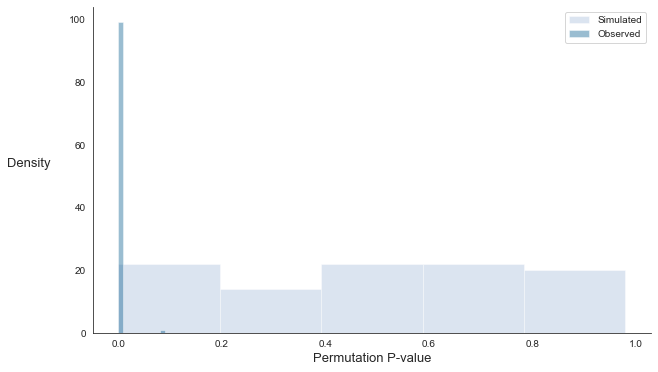

In [28]:
# Test the predictive C.I.T with a prior sample
%pdb on
post_sim_sample = x_samples_post[:, cols_for_test, chosen_sim_idx]
post_pval_sim, post_sampled_pvals_sim, post_obs_pvals_sim =\
    perform_visual_predictive_cit_test(
        posterior_samples_triplet,
        post_sim_sample)

In [29]:
post_sampled_pvals_sim

array([0.24, 0.15, 0.87, 0.29, 0.5 , 0.78, 0.77, 0.62, 0.69, 0.08, 0.01,
       0.66, 0.75, 0.34, 0.67, 0.81, 0.7 , 0.45, 0.49, 0.68, 0.  , 0.34,
       0.39, 0.5 , 0.15, 0.51, 0.03, 0.03, 0.47, 0.06, 0.24, 0.42, 0.4 ,
       0.45, 0.06, 0.94, 0.68, 0.85, 0.83, 0.44, 0.56, 0.38, 0.2 , 0.11,
       0.63, 0.73, 0.4 , 0.08, 0.93, 0.25, 0.03, 0.9 , 0.89, 0.64, 0.61,
       0.81, 0.55, 0.43, 0.06, 0.97, 0.19, 0.19, 0.36, 0.09, 0.89, 0.67,
       0.87, 0.82, 0.5 , 0.69, 0.04, 0.72, 0.66, 0.46, 0.5 , 0.15, 0.6 ,
       0.41, 0.  , 0.51, 0.22, 0.43, 0.54, 0.06, 0.88, 0.84, 0.24, 0.97,
       0.32, 0.02, 0.42, 0.84, 0.61, 0.76, 0.98, 0.22, 0.68, 0.  , 0.97,
       0.85])

In [30]:
post_obs_pvals_sim

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  ])

# Conclusions
From the results above, a few things are apparent.

1. The prior distribution for this particular implementation of the deconfounder is a very poor description of reality. A-priori, our prior beliefs are in severe conflict with our data and are likely in need or revising to be more plausible. For instance, we should never be simulating negative values for `total_travel_distance`.
2. The posterior distribution for this particular implementation of the deconfounder is still a poor description of our data.
3. In order for the predictive conditional independence tests to pass, the inferred latent confounder values must be extremely close to the true latent confounder values. This provides a secondary piece of evidence supporting the finding from Hassan's deconfounder investigation.
   1. The only instance of the test of the deconfounder that succeeded in generating a non-zero p-value (see cell above) is the instance where the value being used as the "observation" was paired with its own latent confounders.
   2. In order for many instances of the test of the deconfounder to succeed in generating non-zero p-values, we'd need most of the simulated latent confounder values to cluster around their true latent confounder values.